In [1]:
import numpy as np
import pandas as pd

# graphical libs
import matplotlib.pyplot as plt
%matplotlib widget
import seaborn as sns

# ml libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler 

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.utils import plot_model

from scipy.signal import savgol_filter
from collections import deque

# set number of rows ti display
#pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# lib for interpretator processing
import sys, os
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Hide output
from IPython.display import clear_output
np.set_printoptions(suppress=True)

# Model serialization
#import pickle
import joblib

import serial
import time

In [2]:
import random

# Fix seed
seed_value = 32
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 1. initiate random seed in Python
random.seed(seed_value)

# 2. initiate random seed in Numpy
np.random.seed(seed_value)


# 3. initiate random seed in tensorflow 
tf.random.set_seed(seed_value)
 
# 4. Конфигурация Tenzorflow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
# Создадим папку data, если такой папки нет
if not os.path.exists("./model"):
    os.mkdir("model")

In [4]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Read files

In [5]:
palm_file_3_1 = './data/sprint3_pilote1_mount1_gestures.palm'

gestures_3_1 = read_omg_csv(palm_file_3_1, 
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0)

print(gestures_3_1.shape)
display(gestures_3_1.head(3))

# train_test_div_num = int(len(gestures_3_1)*0.8)
# gestures_train_3_1 = gestures_3_1.iloc[:train_test_div_num]
# gestures_test_3_1 = gestures_3_1.iloc[train_test_div_num:]
# print('train :', gestures_train_3_1.shape, 'test: ', gestures_test_3_1.shape)

(19569, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,6,0,7,0,0,12,0,13,20,0,...,57,6,22,27,19,0,0,0,34,980322
1,6,4,1,5,9,2,10,2,13,6,...,28,6,22,27,19,0,0,0,34,980355
2,9,0,4,15,2,8,22,9,10,14,...,7,6,22,27,19,0,0,0,34,980388


In [6]:
palm_file_3_2 = './data/sprint3_pilote1_mount2_gestures.palm'
gestures_3_2 = read_omg_csv(palm_file_3_2, 
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0)

print(gestures_3_2.shape)
display(gestures_3_2.head(3))

# train_test_div_num = int(len(gestures_3_2)*0.8)
# gestures_train_3_2 = gestures_3_2.iloc[:train_test_div_num]
# gestures_test_3_2 = gestures_3_2.iloc[train_test_div_num:]
# print('train: ' ,gestures_train_3_2.shape, 'test: ', gestures_test_3_2.shape)

(19628, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,9,8,0,2,22,10,4,6,7,28,...,5,17,27,38,34,11,0,0,0,253431
1,4,11,0,16,0,9,1,5,16,0,...,3,17,27,38,34,11,0,0,0,253464
2,8,9,4,0,4,22,4,5,16,0,...,-1,17,27,38,34,11,0,0,0,253497


### Gestures train and test

In [7]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
# ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = GLOVE_CH[:-1]  # Limit sensors number to 5

BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

#assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == gestures_3_1.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"GLOVE_CH: {list(GLOVE_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


### functions

In [8]:
def callbacks(lr):
   
    # сохранение лучшей модели
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        os.path.join('./model', 'best_model' +'.hdf5'), 
        monitor='val_mse', 
        verbose=1, 
        mode='min', 
        save_best_only=True
    )

    # остановка обучения при отсутствии улучшения заданной метрики
    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor='val_mse', 
        mode='min', 
        patience=50, # 50
        restore_best_weights=True
    )

    # снижение learning rate при отсутствии улучшения заданной метрики 
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_mse', 
        mode='min',  
        factor=0.5,  # 0.5
        patience=20,  # 20
        verbose=1, 
        min_lr=lr/1000
    )
    
    return [checkpoint, earlystop, reduce_lr]

In [9]:
def reset_random_seeds(seed_value):
    """Функция задания seed
    """
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    tf.random.set_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)

In [10]:
def get_active_sensors(arr:np.array):
    # создаём список из активных сенсоров
    sensors = list()
    for i in range(len(OMG_CH)):
        if np.mean(arr[:,i])>200:
            sensors.append(i)
    return sensors

In [11]:
def get_means(df:np.array, sensors:list):
    """get sensor means and std

    Args:
        df (pd.DataFrame): original dataframe
        sensors (list, optional): sensor index. Defaults to sensors.

    Returns:
        (dict): dictionary with sensor means and stds
    """    
    ranges = dict() 

    # словарь из данных активных сенсоров: среднее и ст. откл
    for i in sensors:
        ranges[i] = [np.mean(df[:,i]).round(5), np.std(df[:,i]).round()]
    
    return ranges

In [12]:
def get_limits(arr, iqrs=None):
    """ Replace outliers with +/- 1.5*Interquartile range

    Args:
        df (pd.DataFrame): _description_
        iqrs (list, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """    
    # сохраняем пределы измерения
    if iqrs is None : #or len(iqrs) == 0
        iqrs = dict() 
        
        # Заменяем выбросы на нижнюю и верхнюю границу в цикле
        for i in range(len(OMG_CH)):
            #i = int(i)
            IQR  = np.quantile(arr[:,i], .75) - np.quantile(arr[:,i], .25)
            low  = np.quantile(arr[:,i], .25) - 1.5*IQR
            high = np.quantile(arr[:,i], .75) + 1.5*IQR
            
            # добавляем в список граничные значения сигналов
            iqrs[i] = [low, high]
            # Обрезка выбросов по границе окна
            arr[:,i] = np.clip(arr[:,i], low, high)
            
        return arr, iqrs
        
    else:
        #iqrs = iqrs
    
        # Заменяем выбросы на нижнюю и верхнюю границу в цикле
        for i in range(len(OMG_CH)):
            #i = int(i)
            #IQR =  IQR[i]
            #low  = np.quantile(arr[:,i], .25) - 1.5*iqrs[i]
            #high = np.quantile(arr[:,i], .75) + 1.5*iqrs[i]
            
            #low_limits.append(low)
            #high_limits.append(high)

            arr[:,i] = np.clip(arr[:,i], iqrs[i][0], iqrs[i][1])
        
    return arr

In [13]:
def add_diff(arr:np.array, shift_=1)-> np.array:
    """Concatenation of a array values with shifted by a given step values.

    Args:
        arr (np.array): exhisting array
        shift_ (int, optional): shift of a rolling window. Defaults to 1.

    Returns:
        (np.array): concatenated array
    """    
    diff_arr = np.vstack([np.zeros((shift_, arr.shape[1])), (arr-np.roll(arr, shift_, axis=0))[shift_:]])
    return np.hstack([arr, diff_arr])

In [14]:
def get_mse(y_test:np.array, 
            y_pred:np.array, 
            y_train:np.array=None, 
            y_pred_train:np.array=None, 
            #GLOVE_CH=GLOVE_CH
            ): #, displays_train_test:int=False
    """Display MSE metrics for the test sample
    
    Arguments:
    ---------
    y_test (np.array) - target values from the test sample 
    y_pred (np.array) - predictions for the test sample
    y_train (np.array) - target values from the train sample 
    y_pred_train (np.array) - predictions for the train sample
    GLOVE_CH (list) - target names
    train_test (bool) - var for displaying metrics for train and test samples. By default displays only for the test sample
    ------
    """
    #GLOVE_CH = GLOVE_CH[:-1]  # Limit sensors number to 5
    #y_test = y_test * 100 # multiplication of test values
    
    metrics_test = np.array([mean_squared_error(y_test[:,col], y_pred[:,col]) for col in range(len(GLOVE_CH))]).round(1) # for Numpy
    
    #display(pd.DataFrame({'Test':metrics_test}, index=GLOVE_CH))
    
    if y_train is not None and y_pred_train is not None:
        #y_train = y_train * 100 # multiplication of test values
        metrics_train = np.array([mean_squared_error(y_train[:,col], y_pred_train[:,col]) for col in range(y_train.shape[1])]).round(1)
        display(pd.DataFrame({'Train':metrics_train, 'Test': metrics_test}, index=GLOVE_CH))
        
    else:
        display(pd.DataFrame({'Test':metrics_test}, index=GLOVE_CH))
    

In [15]:
def get_signals_comparison_plot(
    #y_train:np.array, 
    y_test:np.array, y_pred:np.array
    ):
    """Displays test and predicted data on the same plot

    Args:
        y_train (np.array): targets (dependent variables) of the train sample
        y_test  (np.array): targets (dependent variables) of the test sample
        y_pred  (np.array): predicted values for the test sample
        GLOVE_CH (list) - target names
        only_test (int, optional): a lable for displaying the given dataset [0,1]. 
                                Defaults to None and displays train and test data, 1 - display only test data
        
    """    
    fig, ax = plt.subplots(1, 1, figsize=(10, 4)) # plt.sca(axes)

    #GLOVE_CH = GLOVE_CH[:-1]
    #y_test = y_test * 100 # multiplication of test values
    
    # Слагаемые для разделения показаний датчиков
    yticks = np.arange(len(GLOVE_CH)) * 200
    lines, labels = [], []
    indexes = np.arange(y_test.shape[0])
    
    # Display only test data
    p = plt.plot(indexes, np.subtract(y_test, yticks), c='C0')
    lines += [p[0]]
    #labels += ['y_true']

    p = plt.plot(indexes, np.subtract(y_pred, yticks), c='C1', linestyle='-')
    lines += [p[0]]
    #labels += ['y_pred']
    #plt.axvline(y_train.shape[0] , color='k')
    
    labels = ['y_true', 'y_pred']
    major_ticks = np.linspace(0, round(y_test.shape[0], -2), (np.round(y_test.shape[0], -3)/1000).astype(np.int32)+1)
    ax.set_xticks(major_ticks)
    ax.xaxis.grid(linestyle='--')
    plt.yticks(-yticks, GLOVE_CH)
    plt.legend(lines, labels)
    plt.suptitle(f'Gestures')
    plt.tight_layout();
    

```Python
# Обозначения
[X features] '0', ..., '49' - каналы OMG датчиков
             'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
[y target]   'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5' - координаты пальцев в перчатке GLOVE
'BUTTON' - не используется
'SYNC' - синхронизация данных с протоколом
'ts' - метка времен
```

## Dataset concatenation

### Очищаем данные от выбросов

In [16]:
sensors2 = get_active_sensors(gestures_3_2[OMG_CH].values)
sensors = sensors1 = get_active_sensors(gestures_3_1[OMG_CH].values)

# Проверяем совпадение номеров активных сенсоров для обоих маунтов
assert sensors2 == sensors1

In [17]:
# get sensor means and std
means2 = get_means(gestures_3_2[OMG_CH].values,sensors)
means1 = get_means(gestures_3_1[OMG_CH].values,sensors)

In [18]:
# Определяем список коэффициентов для преобразования сигнала маунта 1 к уровню маунта 2
means_diff = {key: v[0] / means1[key][0] for key, v in means2.items()}

# convert to list
means_diff = list(means_diff.values())

# scale mount 1 up to the range of mount 2
gestures_3_1.iloc[:,sensors] = np.round(gestures_3_1.iloc[:,sensors] * means_diff)

In [19]:
# Определяем диапазоны сигналов для обрезки
gestures_3_2_clipped, iqrs = get_limits(gestures_3_2.values)
gestures_3_1_clipped = get_limits(gestures_3_1.values, iqrs)

In [20]:
#gestures = np.concatenate([gestures_3_2_clipped, gestures_3_1_clipped], axis=0) #.reset_index(drop=True)
#  маунт  2 
gestures = gestures_3_2_clipped

gestures = pd.DataFrame(gestures, columns=gestures_3_2.columns) 
gestures.shape

(19628, 65)

### Scaling the dataset

In [21]:
# Scaling values
scaler = MinMaxScaler(feature_range=(0, 1))
X, y = scaler.fit_transform(gestures[OMG_CH].values), gestures[GLOVE_CH].values/100 

joblib.dump(scaler, os.path.join('./model/', "MinMax_scaler"+'.bin'), compress=True) 
print('X: ', X.shape, 'y: ', y.shape)

X:  (19628, 50) y:  (19628, 5)


In [22]:
# Split data by 2 samples: train, test and valid
X_train, X_test, y_train, y_test= train_test_split(X, y, shuffle=False, test_size=0.2,  random_state=seed_value)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))

Train shape: (15702, 50)
Test shape:  (3926, 50)


In [23]:
# Add differential values
X_train, X_test = add_diff(X_train, shift_=5), add_diff(X_test, shift_=5) 

# Check samples shapes
print('Test add diff shape:  {}'.format(X_test.shape))

Test add diff shape:  (3926, 100)


# Modeling

### Модель с обучением по batch

In [24]:
duration = 40
ts_events = np.arange(0, len(X_train), 15)

X_train_nn = [X_train[ts_event : ts_event + duration] for ts_event in ts_events]
y_train_nn = [y_train[ts_event : ts_event + duration] for ts_event in ts_events]

X_train_nn = np.array([arr for arr in X_train_nn if arr.shape == X_train_nn[0].shape])
y_train_nn = np.array([arr for arr in y_train_nn if arr.shape == y_train_nn[0].shape])

print('Train :',X_train_nn.shape, y_train_nn.shape)

X_test_nn = [X_test[ts_event : ts_event + duration] for ts_event in ts_events]
y_test_nn = [y_test[ts_event : ts_event + duration] for ts_event in ts_events]

X_test_nn = np.array([arr for arr in X_test_nn if arr.shape == X_test_nn[0].shape])
y_test_nn = np.array([arr for arr in y_test_nn if arr.shape == y_test_nn[0].shape])

print('Test :', X_test_nn.shape, y_test_nn.shape)


Train : (1045, 40, 100) (1045, 40, 5)
Test : (260, 40, 100) (260, 40, 5)


In [25]:
reset_random_seeds(seed_value)

n_timesteps = None
n_channels = X_train_nn.shape[-1] 
output_units = y_train_nn.shape[-1]

# model architecture
input_layer = x = tf.keras.layers.Input(shape=(n_timesteps, n_channels))

#x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.LSTM(units=100, 
                         #recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                         return_sequences=True,
                         )(x) 
x = tf.keras.layers.Dropout(0.5)(x) #0.3

#output_layer = tf.keras.layers.Dense(units=output_units, activation='elu')(x)

output_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(
        units=output_units,
        activation='relu',
    ))(x)

model = tf.keras.Model(
    inputs=input_layer,
    outputs=output_layer,
    name="model_LSTM"
    )

model.summary()

tf.keras.backend.clear_session()

reset_random_seeds(seed_value)

model.compile(
    loss="mean_squared_error", 
    metrics=['mse'], 
    optimizer=tf.keras.optimizers.experimental.AdamW(learning_rate=0.001) #learning_rate=0.001
)

#callbacks_list = callbacks(1e-03, 'LSTM-60-5') #

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 100)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 100)         80400     
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 time_distributed (TimeDistr  (None, None, 5)          505       
 ibuted)                                                         
                                                                 
Total params: 80,905
Trainable params: 80,905
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(
    X_train_nn,
    y_train_nn, 
    epochs=500,
    validation_split=0.1,
    verbose=1,
    callbacks=callbacks(1e-04)
)

clear_output(False)

In [27]:
# plot_model(model)
#plot_history(history, model.name)

### Prediction

1/1 [==============================] - 0s 487ms/step


,Test
ENC0,99.3
ENC1,83.4
ENC2,69.7
ENC3,93.8
ENC4,83.3


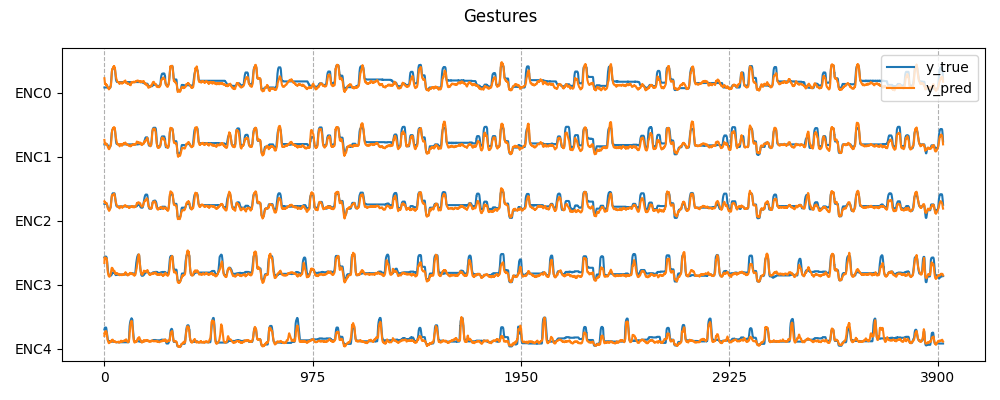

In [28]:
# Loanding saved model
model = tf.keras.models.load_model('./model/best_model.hdf5')

y_pred_test = np.round(model.predict(X_test[None, :])[0]*100) 

get_mse(y_test*100, y_pred_test)

# Display comparison plot
get_signals_comparison_plot(y_test*100, y_pred_test)

## Model_stateful

In [29]:
# model  for inference
hidden_size = 100
n_timesteps = None

n_channels = X_train_nn.shape[-1]
output_units = y_train_nn.shape[-1]
print(f"input_shape = {(n_timesteps, n_channels)} | output_units = {output_units}")


model_input = tf.keras.Input(batch_shape=(1, 1, n_channels))

x = model_input #tf.keras.layers.BatchNormalization()(model_input)

x = tf.keras.layers.LSTM(
    units=hidden_size,
    return_sequences=True,
    stateful=True,
    unroll=True
)(x)

x = tf.keras.layers.Dropout(0.5)(x)

model_output = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(
        units=output_units,
        activation='relu',
    ),
)(x)

model_stateful = tf.keras.Model(
    inputs=[model_input],
    outputs=[model_output],
    name='model_stateful'
)

# # # Загрузка модели из памяти
#model = tf.keras.models.load_model('./model/best_model.hdf5')

# Загрузка весов из памяти
#model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'best_model.hdf5'))

model_stateful.set_weights(model.get_weights())

model_stateful.summary()

input_shape = (None, 100) | output_units = 5
Model: "model_stateful"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 1, 100)]             0         
                                                                 
 lstm (LSTM)                 (1, 1, 100)               80400     
                                                                 
 dropout (Dropout)           (1, 1, 100)               0         
                                                                 
 time_distributed (TimeDistr  (1, 1, 5)                505       
 ibuted)                                                         
                                                                 
Total params: 80,905
Trainable params: 80,905
Non-trainable params: 0
_________________________________________________________________


In [30]:
check_data = gestures_3_2.loc[1000:3500,OMG_CH].values.astype(np.int16).copy()
predicts = list()

# Скалируем
scaler = joblib.load('./model/MinMax_scaler.bin')
check_data_scaled = scaler.transform(check_data)

# добавляем дифф
check_data_diff  = add_diff(check_data_scaled, shift_=5)

for i in range(check_data_scaled.shape[0]):
    x = np.expand_dims(np.expand_dims(check_data_diff[i,:], 0), 0).astype(np.float16)
    #y_pred = (model_stateful.predict(x)[0][0]).astype(np.float16) - считает медленно
    y_pred = model_stateful(x.reshape(1,1,-1)).numpy()[0][0]
    predicts.append(np.round(y_pred, 2))

y_pred_stateful = np.vstack(predicts)
clear_output(wait=False)

# Для примера выводим 2 первых предсказания
y_pred_stateful[:2,:]

array([[0.26, 0.31, 0.39, 0.32, 0.17],
       [0.29, 0.35, 0.41, 0.29, 0.12]], dtype=float32)

,Test
ENC0,8.0
ENC1,8.6
ENC2,7.5
ENC3,8.5
ENC4,10.9


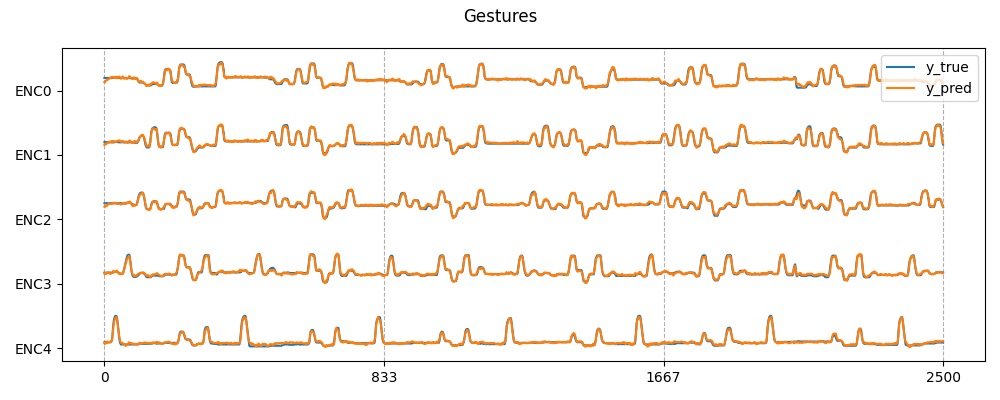

In [31]:
# Display metrics
temp = gestures_3_2.loc[1000:3500, GLOVE_CH].values.astype(np.int16).copy()
get_mse(temp, y_pred_stateful*100)

# Display comparison plot
get_signals_comparison_plot(temp, y_pred_stateful*100)

## Postprocessing

,Test
ENC0,9.1
ENC1,10.6
ENC2,8.9
ENC3,10.1
ENC4,12.5


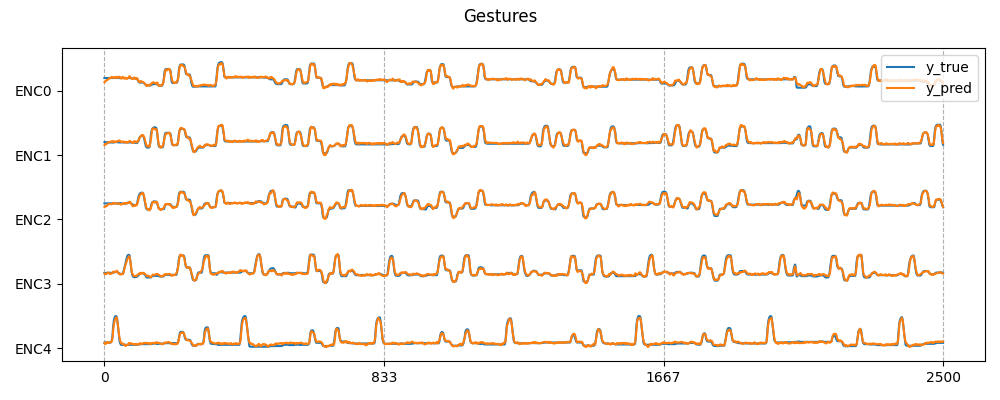

In [32]:
preproc_coef = 0.57
prev = None

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*preproc_coef + prev*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1
    return y

y_pred = y_pred_stateful
# пропускаем нулевой элемент
y_pred_test_proc = np.zeros_like(y_pred)
y_pred_test_proc[0] = y_pred[0]


for i in range(1, len(y_pred)):
    y_pred_test_proc[i] = postprocessing(y_pred[i], y_pred[i-1])

# округление
#y_pred_test_proc = pd.DataFrame(y_pred_test_proc, columns = [GLOVE_CH]).round() # или np.rint()

# преобразование значений в заданный диапазон 
y_pred_test_proc = np.round(np.clip(y_pred_test_proc, 0, 100), 2) 

# Display metrics
temp = gestures_3_2.loc[1000:3500, GLOVE_CH].values.astype(np.int16).copy()
get_mse(temp, y_pred_test_proc*100)

# Display comparison plot
get_signals_comparison_plot(temp, y_pred_test_proc*100)

# Real-time inference

In [33]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils

In [34]:
# #df_sim = gestures.iloc[450:461].copy()
# df_sim =  gestures_3_2.loc[2000:2100, OMG_CH].values.astype(np.int16).copy()
# df_sim.shape

# # Возьмем элемент 460 для наглядности
# x = df_sim[-1,:]
# x

In [35]:
# Scaling
scaler = joblib.load('./model/MinMax_scaler.bin')

# Empty buffer for data
buff = np.zeros((5,50))
 

def preprocessing(x:np.array, buff:np.array=buff,  scaler=scaler):
    
    buff[0], buff[1], buff[2], buff[3] = buff[1], buff[2], buff[3], buff[4]
    
    #x - sample vector
    x_scaled = scaler.transform(x.reshape(1,-1))[0]
    
    buff[4] =  x_scaled 
    
    y = np.hstack([x_scaled, buff[4]- buff[3]])
    
    buff = np.transpose([savgol_filter(buff[:,i], window_length=5, polyorder=2, axis=0) for i in range(buff.shape[1])])[:,:5]
    
    return y, buff 

In [36]:
# arr = np.array([[1,1,1],[2,2,2],[4,4,4], [7,7,7],[11,11,11],[16,16,16]])
# shift_=1
# add_diff(arr)

In [37]:
buff = np.zeros((6,50))
def preprocessing2(x:np.array, buff:np.array=buff):
    
    buff[0], buff[1], buff[2], buff[3], buff[4] = buff[1], buff[2], buff[3], buff[4], buff[5]
    
    #x - sample vector
    x_scaled = scaler.transform(x.reshape(1,-1))[0]
    
    buff[5] = x_scaled
    
    # Можно выбрать длину диффа
    y = np.hstack([x_scaled, buff[5]- buff[1]])
    
    #buff = np.transpose([savgol_filter(buff[:,i], window_length=6, polyorder=2, axis=0) for i in range(buff.shape[1])])[:,:5]
    
    return y, buff

# arr = np.array([[1,1,1],[2,2,2],[4,4,4], [7,7,7],[11,11,11],[16,16,16]])
# buff = np.zeros((8,3))
# ss = list()

# for i in range(arr.shape[0]):
#     ss.append(preprocessing2(arr[i]))

# ss

In [38]:
# for i in range(df_sim.shape[0]):
#     y, buff = preprocessing(df_sim[i])
    
#y, buff = preprocessing(df_sim[-1])
#y_1, buff = preprocessing(df_sim[-2])

In [39]:
#x = y.copy()

# [Различные варианты загрузки моделей]-------------------------


# # -----Loading LSTM model--------
#saved_model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'model_LSTM'))
#saved_model = model

# # ----- model stateful--------
saved_model = model_stateful


def inference(x:np.array, saved_model=saved_model)->np.array: 
    """Get inference using saved model

    Args:
        x (np.array): input vector
        saved_model (...): ml model

    Returns:
        (np.array): preiction
    """
 
    # For LSTM model
    if saved_model.name == 'LSTM_tuned':
        x = x.reshape(1,-1)
        #y_pred = saved_model.predict(np.expand_dims(x, 1))[0].round()
        y_pred = np.round(saved_model.predict(X_test[None, :])[0]*100)
    
    # For stateful model
    else:
        #y_pred = saved_model(np.expand_dims(x, 1)) #.round()

        #y_pred = saved_model.predict(x).round(2)
        #x = np.expand_dims(np.expand_dims(x, 0), 0).astype(np.float16)
        #y_pred = (saved_model.predict(x)[0][0]).astype(np.float16)
        y_pred = saved_model(x.reshape(1,1,-1)).numpy()[0][0]
        
    return y_pred*100

#predict = inference(x, saved_model=saved_model)
#predict

In [40]:
# predict_0 = inference(y, saved_model=saved_model)
# predict_1 = inference(y_1, saved_model=saved_model)
# print(predict_0, predict_1)

In [41]:
# set empty buffer
buff_pred = np.zeros((2,5))

def postprocessing(x:np.array, prev:np.array=None, preproc_coef:float=0.57)->np.array:
    """postprocessing of prediction

    Args:
        x (np.array): predict.
        buff_pred (np.array): prediction buffer
        preproc_coef (float, optional): preprocessing coefficient Defaults to 0.57.

    Returns:
        np.array: _description_
    """    
    #buff_pred[1], buff_pred[0] = buff_pred[0], np.clip(predict, 0, 100)
    
    if prev is None:
        y = x
       
    else:
        y = x*preproc_coef + prev*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1
    
    #y = np.clip(y, 0, 100)

    return y

In [42]:
# res0 = postprocessing(predict_0, buff_pred).round()[0]
# res1   = postprocessing(predict_1, buff_pred).round()[0]
# print(res0, res1)

In [43]:
def commands(x):
    y = np.round(np.clip(x , 0, 100)).astype(int)
    return y

dq = deque(maxlen=5)
def commands1(dq):
    """_сглаживатель пиков по 2-м предыдущим шагам_
    """
    if len(dq) < 5:
        return np.zeros(5)
    else:
        if (dq[-1] == dq[0]).any(): # если хотя бы 1 элемент не соответствует
            dq[1][dq[-1] == dq[0]] = dq[0][dq[-1] == dq[0]]
            
    return np.round(np.array([
        np.mean([dq[0][0],dq[-1][0]]),
        np.mean([dq[0][1],dq[-1][1]]),
        np.mean([dq[0][2],dq[-1][2]]),
        np.mean([dq[0][3],dq[-1][3]]),
        np.mean([dq[0][4],dq[-1][4]])
    ]))

def commands2(dq):
    """_сглаживатель пиков по 2-м предыдущим шагам_
    """
    if len(dq) < 5:
        return np.zeros(5)
    else:
        if (dq[-1] == dq[0]).any(): # если хотя бы 1 элемент не соответствует
            dq[1][dq[-1] == dq[0]] = dq[0][dq[-1] == dq[0]]
            
    return np.round(np.array([
        np.mean([dq[0][0],dq[1][0], dq[2][0],dq[3][0],dq[4][0]]),
        np.mean([dq[0][1],dq[1][1], dq[2][1],dq[3][1],dq[4][1]]),
        np.mean([dq[0][2],dq[1][2], dq[2][2],dq[3][2],dq[4][2]]),
        np.mean([dq[0][3],dq[1][3], dq[2][3],dq[3][3],dq[4][3]]),
        np.mean([dq[0][4],dq[1][4], dq[2][4],dq[3][4],dq[4][4]])
    ]))

## Эмуляция

In [44]:
df_sim = gestures_3_2.loc[2000:2500, :]#.astype(np.int16).copy()

print(df_sim.shape)

(501, 65)


In [45]:
# В промежуток 0.033 с модель не проходит
TIMEOUT = 1 #0.033
DEBUG = True

ts_list = [] 

model_stateful.reset_states()

i = 0
preproc_coef = 0.57
buff = np.zeros((6,50))
buff_pred = np.ones((5,5))*np.array([.5,.5,.5,.5,.5])
ts_diff = 0 
dq = deque(buff_pred, maxlen=5)
y_previous = np.array([.32,.35,.45,.30,.10])

y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    'y_commands1':[],
    'ts_time':[],
}


saved_model = model_stateful

 
ts_old = time.time()

# Check input data format and shape
try:
    assert (type(df_sim), df_sim.shape) == (pd.DataFrame, (100,65))
except AssertionError as e1:
    print('Type(df_sim) must be pd.DataFrame, shape (100,65)')

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
    
    except Exception as e:
        print(e)
    
    # [Data preprocessing]
    #sample_preprocessed, buff = preprocessing(omg_sample)
    sample_preprocessed, buff = preprocessing2(omg_sample)
    
    # [Inference for   LSTM]
    y_predicted         = inference(sample_preprocessed)
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)  
    
    dq.append(y_postprocessed)
    
    # [Commands composition]
    # y_commands          = commands_new(y_postprocessed, y_previous, sample_preprocessed) #y_postprocessed
    y_commands          = commands(y_postprocessed)
    y_commands1          = commands2(dq)

    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)      # полученные команды
    y_dct['y_commands1'].append(y_commands1)    # сглаженные команды
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        #sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        
    
    ts_diff = time.time() - ts_start 
    y_dct['ts_time'].append(ts_diff) # проверю времена выполнения
    
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 

#print(f'Время вычисления: {np.mean(ts_list).round(3)} мс')

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 0, SYNC: 60, TS: 335931


In [46]:
# Display metrics
temp = np.array(y_dct['enc_sample'])[:,:5]
get_mse(temp, np.array(y_dct['y_commands']))

,Test
ENC0,42.2
ENC1,35.8
ENC2,26.9
ENC3,99.1
ENC4,44.4


In [47]:
# temp = pd.DataFrame({
#     'preprocessing2(4)':[44.7, 34.2, 31.8, 48.2, 47.7],
#     'preprocessing0':[79.2, 73.9, 62.5, 67.4, 60.2]})

# temp.loc['mean'] = temp.mean()
# temp

#### Сохранение списка из времен получения инференса

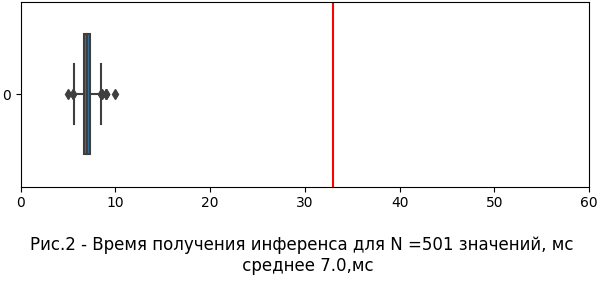

In [48]:
# Загрузка сохраненного списка
times =  y_dct['ts_time'] #pd.read_csv(os.path.join(PATH, 'times.csv'), index_col=0) 


fig, ax = plt.subplots(1,1, figsize=(6,3))
fig = sns.boxplot(data=np.array([times])*1000, orient='h', width=0.65)
ax.set_xlim(0,60)
ax.axvline(33, color='r')#, color='r', ls=':')
ax.set_title(f'Рис.2 - Время получения инференса для N ={len(times)} значений, мc \n среднее {np.round(np.mean(np.array([times]))*1000)},мс', y=-0.5)
plt.tight_layout(pad=0.15);
#plt.subplots_adjust(right=1.1)

#plt.savefig(f'../figures/fig_2.png')

#times.agg(['mean','std']).round(3)*1000

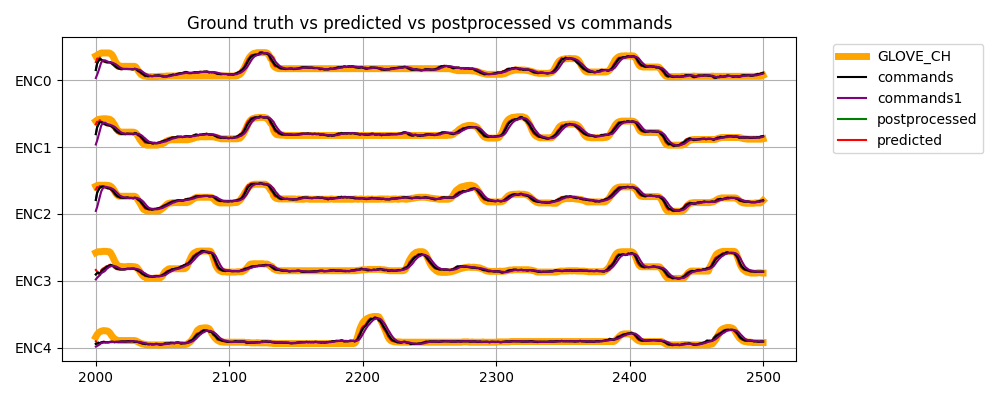

In [49]:
xticks = df_sim[GLOVE_CH].index
dist = -np.arange(len(GLOVE_CH)) * 200

fig, ax = plt.subplots(1, 1,  figsize=(10, 4))

ax.plot(xticks, df_sim[GLOVE_CH] + dist, c='orange', label='GLOVE_CH' ,linewidth=5 ) # 
ax.plot(xticks,   y_dct['y_predicted'] + dist, c='red', label ='predicted')
ax.plot(xticks,   y_dct['y_postprocessed'] + dist, c='green', label ='postprocessed')
ax.plot(xticks,   y_dct['y_commands'] + dist, c='k', label ='commands')
ax.plot(xticks,   y_dct['y_commands1'] + dist, c='purple', label ='commands1')
#ax.plot(xticks,   NEW + dist, c='red', label ='LSTM + nogo commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(dist, GLOVE_CH)

# get unique labels
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax.legend(handles, labels, bbox_to_anchor=[1.04, 1]) 

plt.grid()
plt.tight_layout()

#plt.savefig(f'../figures/fig_4.png')

## Inference

### Offline (dataset)

#### Тестируем на 2 монтаже

In [50]:
df_sim = gestures_3_2.iloc[2000:5000]  
print(df_sim.shape)

TIMEOUT = 1 # 0.33
DEBUG = True
    
i = 0
ts_diff = 0

buff = np.zeros((6,50))
buff_pred = np.ones((5,5))*np.array([.5,.5,.5,.5,.5])
ts_old = time.time()
y_previous = None
x_previous = np.zeros((5))
dq = deque(buff_pred, maxlen=5)

y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    'y_commands1':[],
    'ts_time':[]
}

# [Различные варианты загрузки моделей]-------------------------
# # -----Loading LSTM model--------
# saved_model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'model_LSTM'))

# ----- model stateful--------
saved_model = model_stateful

# # # -----Модель Logistic regression--------
# with open(os.path.join(config.PATH_MODEL+'log_reg.pkl'), 'rb') as f:
#     log_reg = pickle.load(f)


while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
    
    except Exception as e:
        print(e)
    
    # [Data preprocessing]
    sample_preprocessed, buff = preprocessing2(omg_sample)
    
    # [Inference for   LSTM]
    y_predicted         = inference(sample_preprocessed) 
 
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous) #, preproc_coef=0.3
    
    dq.append(y_postprocessed)
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    y_commands1         = commands2(dq)


    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)      # полученные команды
    y_dct['y_commands1'].append(y_commands1)    # сглаженные команды
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        #sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        
    
    ts_diff = time.time() - ts_start
    #ts_list.append(ts_diff) 
    y_dct['ts_time'].append(ts_diff) # проверю времена выполнения
    
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 0, SYNC: 124, TS: 418398


In [51]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (3000, 50)
enc_sample.shape = (3000, 6)
sample_preprocessed.shape = (3000, 100)
y_predicted.shape = (3000, 5)
y_postprocessed.shape = (3000, 5)
y_commands.shape = (3000, 5)
y_commands1.shape = (3000, 5)
ts_time.shape = (3000,)


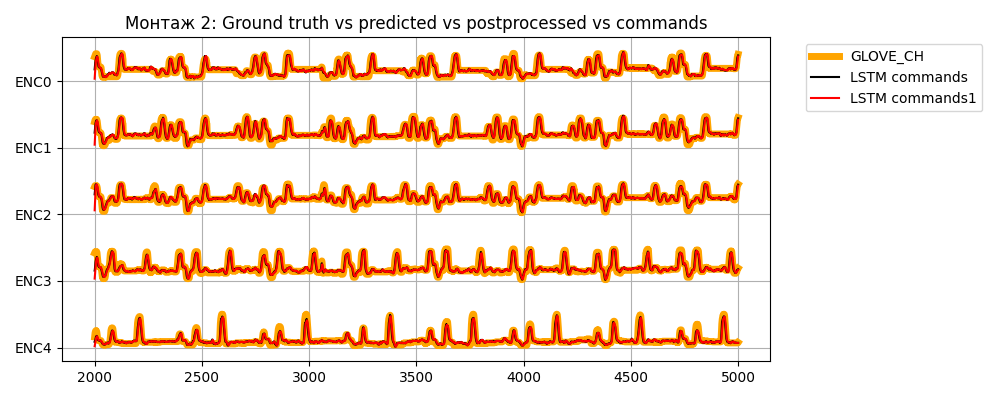

In [52]:
xticks = df_sim[GLOVE_CH].index
dist = -np.arange(len(GLOVE_CH)) * 200

fig, ax = plt.subplots(1, 1,  figsize=(10, 4))

ax.plot(xticks, df_sim[GLOVE_CH] + dist, c='orange', label='GLOVE_CH',linewidth=5)#, label='GLOVE_CH'
#ax.plot(xticks,   np.array(y_dct['y_postprocessed']) + dist, c='red', label ='LSTM postprocessed') # + nogo commands
ax.plot(xticks,   np.array(y_dct['y_commands']) + dist, c='black', label ='LSTM commands') # + nogo commands
ax.plot(xticks,   np.array(y_dct['y_commands1']) + dist, c='red', label ='LSTM commands1')

plt.title('Монтаж 2: Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(dist, GLOVE_CH)

# get unique labels
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax.legend(handles, labels, bbox_to_anchor=[1.04, 1]) 

plt.grid()
plt.tight_layout()

#plt.savefig(f'../figures/fig_4.png')

#### Тестируем на 1 монтаже

In [53]:
gestures_3_1_clipped = pd.DataFrame(gestures_3_1_clipped, columns=gestures_3_1.columns)
df_sim = gestures_3_1_clipped.iloc[2000:5000]  
print(df_sim.shape)

TIMEOUT = 1 # 0.33
DEBUG = True
    
i = 0
ts_diff = 0

buff = np.zeros((6,50))
buff_pred = np.ones((5,5))*np.array([.5,.5,.5,.5,.5])
ts_old = time.time()
y_previous = None
x_previous = np.zeros((5))
dq = deque(buff_pred, maxlen=5)

y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    'y_commands1':[],
    'ts_time':[]
}

# [Различные варианты загрузки моделей]-------------------------
# # -----Loading LSTM model--------
# saved_model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'model_LSTM'))

# ----- model stateful--------
saved_model = model_stateful

# # # -----Модель Logistic regression--------
# with open(os.path.join(config.PATH_MODEL+'log_reg.pkl'), 'rb') as f:
#     log_reg = pickle.load(f)


while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
    
    except Exception as e:
        print(e)
    
    # [Data preprocessing]
    sample_preprocessed, buff = preprocessing2(omg_sample)
    
    # [Inference for   LSTM]
    y_predicted         = inference(sample_preprocessed) #model_xgb
    
 
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous) #, preproc_coef=0.3
    
    dq.append(y_postprocessed)
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    y_commands1         = commands2(dq)


    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)      # полученные команды
    y_dct['y_commands1'].append(y_commands1)    # сглаженные команды
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        #sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        
    
    ts_diff = time.time() - ts_start
    #ts_list.append(ts_diff) 
    y_dct['ts_time'].append(ts_diff) # проверю времена выполнения
    
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 0.0, SYNC: 124.0, TS: 1145289.0


In [54]:
# Display metrics
temp = np.array(y_dct['enc_sample'])[:,:5]
get_mse(temp, np.array(y_dct['y_commands']))

,Test
ENC0,587.5
ENC1,837.2
ENC2,556.9
ENC3,682.8
ENC4,517.5


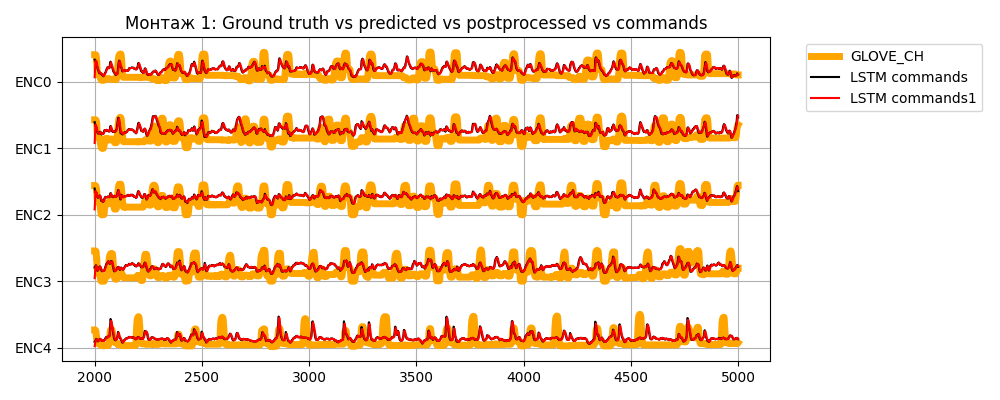

In [55]:
xticks = df_sim[GLOVE_CH].index
dist = -np.arange(len(GLOVE_CH)) * 200

fig, ax = plt.subplots(1, 1,  figsize=(10, 4))

ax.plot(xticks, df_sim[GLOVE_CH] + dist, c='orange', label='GLOVE_CH',linewidth=5)#, label='GLOVE_CH'
#ax.plot(xticks,   np.array(y_dct['y_postprocessed']) + dist, c='red', label ='LSTM postprocessed') # + nogo commands
ax.plot(xticks,   np.array(y_dct['y_commands']) + dist, c='black', label ='LSTM commands') # + nogo commands
ax.plot(xticks,   np.array(y_dct['y_commands1']) + dist, c='red', label ='LSTM commands1')

plt.title('Монтаж 1: Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(dist, GLOVE_CH)

# get unique labels
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax.legend(handles, labels, bbox_to_anchor=[1.04, 1]) 

plt.grid()
plt.tight_layout()

#plt.savefig(f'../figures/fig_4.png')

### Online (prosthesis or virtual hand)

In [56]:
# TIMEOUT = 0.033
# DEBUG = True

# ser = None
# # ser_port = None
# ser_port = '/dev/cu.usbmodem3498365F31351'

# if ser_port is not None:
#     ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
#     ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
#     ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
#     ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

#     # flush buffers
#     ser.reset_input_buffer()
#     ser.read()
    
#     i = 0;
#     while(ser.in_waiting):
#         print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
#         ser.read_all()
#         time.sleep(0.005)
#         i+=1;
#     ser.readline()
#     ser.readline()
    
# i = 0
# ts_old = time.time()
# ts_diff = 0;

# y_previous = None
# while True:    
    
#     # [Data reading]
#     s = ser.readline()
#     ts_start = time.time()
    
#     try:
#         sample = np.array(s.decode('UTF-8')\
#                            .replace('\r\n', "")\
#                            .split(' ')
#                          ).astype(int)
#         [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
#     except Exception as e:
#         print(e)
        
#     # [/Data Reading]
        
#     # [Data preprocessing]
#     sample_preprocessed = preprocessing(omg_sample)
#     # [/Data preprocessing]
    
#     # [Inference]
#     y_predicted         = inference(sample_preprocessed)
#     # [/Inference]
    
#     # [Inference Postprocessing]
#     y_postprocessed     = postprocessing(y_predicted, y_previous)
#     # [/Inference Postprocessing]
    
#     # [Commands composition]
#     y_commands          = commands(y_postprocessed)
#     # [/Commands composition]
    
#     # [Commands sending]
#     pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
#     # [/Commands sending]
    
#     y_previous = y_postprocessed
    
#     if DEBUG:
#         clear_output(wait=True)

#         # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
#         print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
#         print('INPUT:\n', s)

#         # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
#         print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
#         print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
#         print(y_commands)
#         print(pack)
    
#     ts_diff = time.time() - ts_start
#     assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
#     ts_old = ts_start
#     i += 1 